In [45]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [46]:
df = pd.read_csv("name_gender_dataset.csv")

df.head()

,Name,Gender,Count,Probability
0,James,M,5304407,0.014517
1,John,M,5260831,0.014398
2,Robert,M,4970386,0.013603
3,Michael,M,4579950,0.012534
4,William,M,4226608,0.011567


# Preprocessing

In [47]:
df = df.drop(["Probability", "Count"], axis=1)

df.head()

,Name,Gender
0,James,M
1,John,M
2,Robert,M
3,Michael,M
4,William,M


In [48]:
df.columns.isnull()

array([False, False])

In [49]:
df.Gender.unique()

array(['M', 'F'], dtype=object)

In [50]:
df

,Name,Gender
0,James,M
1,John,M
2,Robert,M
3,Michael,M
4,William,M
...,...,...
147264,Zylenn,M
147265,Zymeon,M
147266,Zyndel,M
147267,Zyshan,M


In [51]:
df["Gender"] = LabelEncoder().fit_transform(df.Gender.values)

## Splitting Dataset into x, y and train, test datasets

In [52]:
x_train, x_test , y_train, y_test = train_test_split(df.Name.values, df.Gender.values, test_size=0.2, random_state=2023, stratify=df.Gender.values)

# Setting Some variables for pipleline

In [53]:
alphabet = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ '
vocab_size = len(alphabet)


53

In [54]:
max_length = 15

# Making a Pipeline

In [56]:
class KerasTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, vocab_size=53, char_level=True):  # Default vocab_size includes all lowercase letters plus 1 for Keras' reserved index
        self.tokenizer = Tokenizer(num_words=vocab_size, char_level=char_level)
    
    def fit(self, X, y=None):
        self.tokenizer.fit_on_texts(X)
        return self
    
    def transform(self, X, y=None):
        return self.tokenizer.texts_to_sequences(X)

class KerasSequencePadding(BaseEstimator, TransformerMixin):
    def __init__(self, max_length=10):
        self.max_length = max_length
    
    def fit(self, X, y=None):
        return self  # No fitting needed
    
    def transform(self, X, y=None):
        return pad_sequences(X, maxlen=self.max_length, padding='post')

In [57]:
pipeline = Pipeline([
    ('tokenizer', KerasTokenizer(vocab_size=vocab_size)),
    ('padder', KerasSequencePadding(max_length=max_length))
])

# Fitting the Pipeline

In [58]:
x_train_padded = pipeline.fit_transform(x_train)
x_test_padded = pipeline.transform(x_test)

# Model

In [59]:
from sklearn.neighbors import KNeighborsClassifier

model_KNN = KNeighborsClassifier()
model_KNN.fit(x_train_padded,y_train)

pred_knn = model_KNN.predict(x_test_padded)
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74     17950
           1       0.58      0.49      0.53     11504

    accuracy                           0.66     29454
   macro avg       0.64      0.63      0.63     29454
weighted avg       0.66      0.66      0.66     29454



# Function for visualizing accuracy

In [60]:
def plot_loss(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Binary_Cross_Entropy')
  plt.legend()
  plt.grid(True)
  plt.show()

# Neural Network

In [61]:
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=0,
    verbose=1,
)



model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(50, 50, input_length=max_length),
        tf.keras.layers.LSTM(100, activation="elu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="elu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation="swish"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="elu"),
        tf.keras.layers.Dense(32, activation="swish"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 50)            2500      
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                6464      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [63]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    x_train_padded,
    y_train,
    batch_size=250,
    epochs=200,
    validation_split=0.2,
    verbose=1,
    callbacks=[callback],
)

Epoch 1/200
378/378 [==============================] - 34s 76ms/step - loss: 0.5591 - accuracy: 0.7131 - val_loss: 0.5989 - val_accuracy: 0.6962
Epoch 2/200
378/378 [==============================] - 28s 74ms/step - loss: 0.5021 - accuracy: 0.7610 - val_loss: 0.5083 - val_accuracy: 0.7559
Epoch 3/200
378/378 [==============================] - 27s 72ms/step - loss: 0.4836 - accuracy: 0.7735 - val_loss: 0.4715 - val_accuracy: 0.7799
Epoch 4/200
378/378 [==============================] - 27s 72ms/step - loss: 0.4762 - accuracy: 0.7785 - val_loss: 0.4749 - val_accuracy: 0.7762
Epoch 5/200
378/378 [==============================] - 27s 72ms/step - loss: 0.4717 - accuracy: 0.7794 - val_loss: 0.4648 - val_accuracy: 0.7845
Epoch 6/200
378/378 [==============================] - 27s 72ms/step - loss: 0.4672 - accuracy: 0.7820 - val_loss: 0.4633 - val_accuracy: 0.7861
Epoch 7/200
378/378 [==============================] - 28s 73ms/step - loss: 0.4678 - accuracy: 0.7812 - val_loss: 0.4703 - val_ac

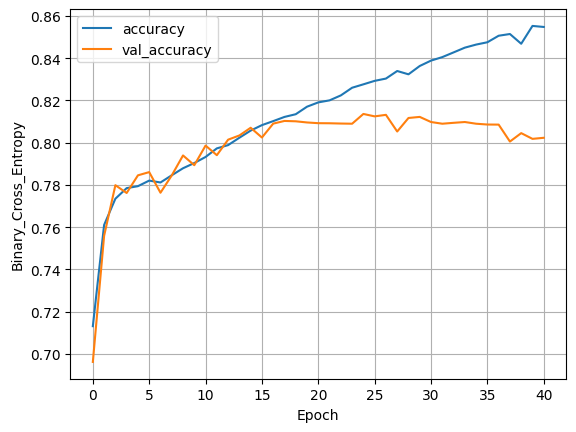

In [64]:
plot_loss(history)

In [65]:
model.save("./81_accuracy.keras")

# Defining Functions for testing the model

In [70]:
def test_model_stats(model):

    """Test the model's statistics."""

    y_pred = model.predict(x_test_padded)

    for i in range(len(y_pred)):
        if y_pred[i] >= 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0


    print(classification_report(y_test, y_pred))

In [71]:
def predict_gender(model):
    a = input("Enter Name")
    a = pipeline.transform(a)
    pred = model.predict(a)
    if pred[0] >= 0.5:
        print("m")
    else:
        print("f")

# Evaluation

In [72]:
test_model_stats(model)
predict_gender(model)

  1/921 [..............................] - ETA: 49s

921/921 [==============================] - 8s 9ms/step
              precision    recall  f1-score   support

           0       0.86      0.83      0.84     17950
           1       0.75      0.79      0.77     11504

    accuracy                           0.81     29454
   macro avg       0.80      0.81      0.81     29454
weighted avg       0.82      0.81      0.81     29454

1/1 [==============================] - 0s 41ms/step
f


In [73]:
model2 = tf.keras.models.load_model('./81_accuracy.keras')
test_model_stats(model2)


921/921 [==============================] - 9s 10ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     17950
           1       0.75      0.76      0.76     11504

    accuracy                           0.81     29454
   macro avg       0.80      0.80      0.80     29454
weighted avg       0.81      0.81      0.81     29454

